In [17]:
import numpy as np
import pandas as pd
import os
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# def extract_song_embeddings(file_path):
#     try:
#         waveform, _ = librosa.load(file_path, sr=16000, mono=True)
#         waveform = waveform.astype(np.float32)

#         _, embbedings, _ = yamnet_model(waveform)
#         song_embeddings = tf.reduce_mean(embbedings, axis=0)
        
#         return song_embeddings.numpy()
#     except:
#         print(f"Error has occured in file path {file_path}")
#         return None
    
def extract_song_embeddings(segment):
    _, embbedings, _ = yamnet_model(segment)
    song_embeddings = tf.reduce_mean(embbedings, axis=0)
        
    return song_embeddings.numpy()

def extract_song_segments(file_path):
    segment_seconds = 5
    overlap_seconds = 0 
    segments = []

    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)

        segment_samples = segment_seconds * sr
        hop_samples = segment_samples - int(overlap_seconds * sr)

        for start in range(0, 
                           len(waveform) - segment_samples + 1, 
                           hop_samples):
                           
            segment = waveform[start: start + segment_samples]
            segments.append(segment)

        return segments
    
    except:
        print(f"Error has occured in file path {file_path}")
        return None

In [8]:
dataset_path = "vibes"
dataset_csv_path = "song_embeddings.csv"

X = []
y = []
vibe_map = {"relaxing": 0,
             "chaotic": 1,
             "chill": 2,
             "energetic": 3}

if not os.path.exists(dataset_csv_path):
    for vibe in os.listdir(dataset_path):
        vibe_path = os.path.join(dataset_path, vibe)
        for file in tqdm(os.listdir(vibe_path), desc=f"Extracting songs embedding in folder {vibe}"):
            file_path = os.path.join(vibe_path, file)
            segments = extract_song_segments(file_path)
            if segments is not None:
                for segment in segments:
                    embeddings = extract_song_embeddings(segment)
                    X.append(embeddings)
                    y.append(vibe_map[vibe])

In [9]:
if not os.path.exists(dataset_csv_path):
    df = pd.DataFrame(X)
    df["label"] = y

    df.to_csv(dataset_csv_path)

In [10]:
df = pd.read_csv(dataset_csv_path,
                 index_col=0)

X = np.array(df.drop(columns=["label"]))
y = np.array(df["label"])

vibe_labels = ["Relaxing", 
               "Chaotic", 
               "Chill", 
               "Energetic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.20,
                                                    stratify=y)

model = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(vibe_labels), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8206 - loss: 0.4722 - val_accuracy: 0.8653 - val_loss: 0.6065
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8661 - loss: 0.3469 - val_accuracy: 0.8914 - val_loss: 0.3769
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8804 - loss: 0.3095 - val_accuracy: 0.8841 - val_loss: 0.4298
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9050 - loss: 0.2656 - val_accuracy: 0.8894 - val_loss: 0.3004
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9026 - loss: 0.2496 - val_accuracy: 0.8914 - val_loss: 0.3047
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9089 - loss: 0.2394 - val_accuracy: 0.8935 - val_loss: 0.2743
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9227 - loss: 0.2121 - val_accuracy: 0.8914 - val_loss: 0.2977
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9240 - loss: 0.2055 - val_accuracy: 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

    Relaxing       0.96      0.96      0.96       358
     Chaotic       0.89      0.90      0.89       240
       Chill       0.92      0.90      0.91       240
   Energetic       0.89      0.91      0.90       359

    accuracy                           0.92      1197
   macro avg       0.92      0.91      0.91      1197
weighted avg       0.92      0.92      0.92      1197



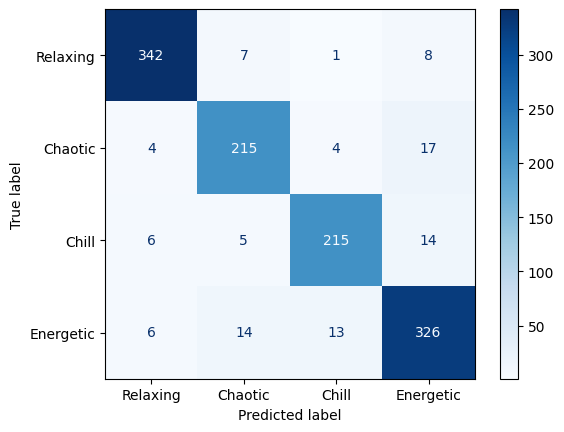

In [ ]:
y_preds = model.predict(X_test)
y_pred_labels = np.argmax(y_preds, axis=1)

print(classification_report(y_test,
                            y_pred_labels,
                            target_names=vibe_labels))

cm = confusion_matrix(y_test,
                      y_pred_labels)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=vibe_labels)
cm_display.plot(cmap="Blues")

In [12]:
z = []
song_segments = extract_song_segments("testing_dataset/chaotic.1.mp3")

for song_segment in song_segments:
    song_embeddings = extract_song_embeddings(song_segment)
    z.append(song_embeddings)

z = np.array(z)

y_pred = model.predict(z)

song_pred = np.mean(y_pred, axis=0)
y_pred_label = np.argmax(song_pred)

print("Predicted Class:", vibe_labels[y_pred_label])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Chaotic
